In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib.pylab import imshow
from skimage.filters import frangi
from matplotlib import pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes
from process_image import process_image
from ipyregulartable import RegularTableWidget as table
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from prepare_image import prepare_image
from joblib import dump, load
from IPython.display import display


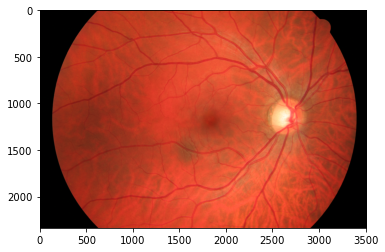

In [41]:
image = cv.imread('data/all/images/01_h.JPG')
imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

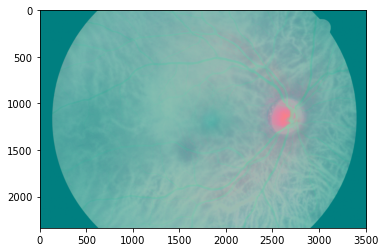

In [57]:
# convert to CIELAB color space and extract lightness
image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
l, a, b = cv.split(image_lab)


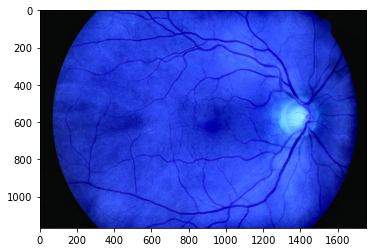

In [58]:
# apply contrast limited adaptive histogram equalization to the L channel
# https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv.createCLAHE(clipLimit = 3.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2BGR)
# imshow(clahe.apply(l))
imshow(merged)


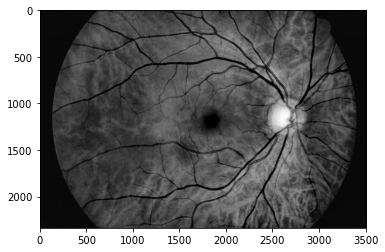

In [60]:
# convert image to BGR and extract green channel (vessels' visibility is the best)
b, g, r = cv.split(merged)

imshow(g, cmap = 'gray')

In [61]:
image_frangi = frangi(g)

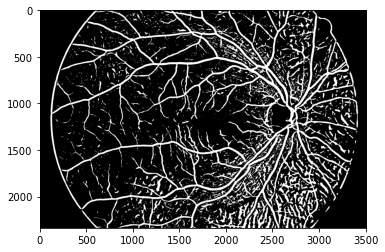

In [68]:
ret, thresh = cv.threshold(
    image_frangi,
    np.mean(image_frangi) * 0.45, 255,
    cv.THRESH_BINARY)  #for healthy eyes *0.4 bc of thin tips
thresh = thresh.astype('uint8')
imshow(thresh, cmap='gray')


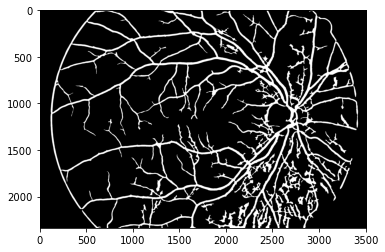

In [63]:
deblobed = thresh > 0
deblobed = remove_small_objects(deblobed, 2500, connectivity = 2)
deblobed = remove_small_holes(deblobed, 900, connectivity = 1)
deblobed = deblobed.astype('uint8') * 255
# (6,6) gives ca 96-98% accuracy and specificity
deblobed = cv.erode(deblobed, cv.getStructuringElement(cv.MORPH_ELLIPSE, (1, 1)))
deblobed = cv.morphologyEx(deblobed, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (12, 12)))
imshow(deblobed, cmap = 'gray')


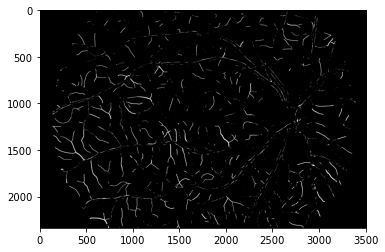

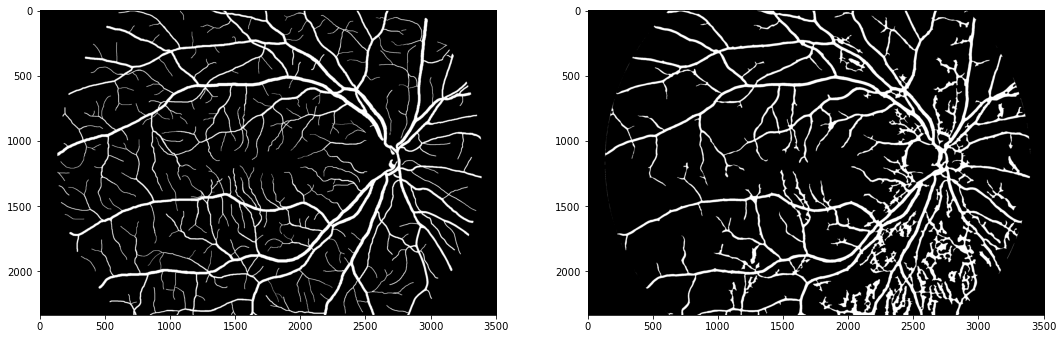

In [64]:
# load the hand-made mask
mask = cv.imread('data/all/manual1/01_h.tif', cv.IMREAD_GRAYSCALE)
cut = cv.imread('data/all/mask/01_h_mask.tif', cv.IMREAD_GRAYSCALE)
cut = cv.bitwise_and(cut, deblobed)
# imshow(mask, cmap='gray')
diff = (mask - cut)
imshow(diff, cmap = 'gray')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(mask, cmap = 'gray')
ax2.imshow(cut, cmap = 'gray')


TN 6912441
FP 439015
FN 167995
TP 665893


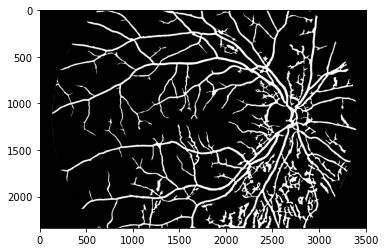

In [69]:
processed = cut
imshow(cut, cmap = 'gray')

image_size = processed.shape[0] * processed.shape[1]

mask_binary = mask.copy()
mask_binary[mask_binary < 127] = 0
mask_binary[mask_binary >= 127] = 1

processed_binary = processed.copy()
processed_binary[processed_binary < 127] = 0
processed_binary[processed_binary >= 127] = 1

#TN, FP, FN, TP = confusion_matrix(mask_binary.flatten(), processed_binary.flatten()).ravel()
TP = np.sum(processed_binary[mask_binary == 1])
FP = np.sum(processed_binary[mask_binary == 0])
FN = np.sum(mask_binary[mask_binary == 1]) - np.sum(processed_binary[mask_binary == 1])
TN = image_size - np.sum(processed_binary[mask_binary == 0]) - TP - FN
print(f'TN', TN)
print(f'FP', FP)
print(f'FN', FN)
print(f'TP', TP)
#print(FN + FP + TP + TN - image_size)


In [70]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)


accuracy: 0.9258418461093388
sensitivity :  0.7985400917149545
specificity:  0.9402818978988652


In [71]:
accuracies = []
sensitivities = []
specificities = []

for i in range(1, 2):
    image = cv.imread('data/all/images/' + str(i).zfill(2) + '_h.JPG')
    manual = cv.imread('data/all/manual1/' + str(i).zfill(2) + '_h.tif', cv.IMREAD_GRAYSCALE)
    mask = cv.imread('data/all/mask/' + str(i).zfill(2) + '_h_mask.tif', cv.IMREAD_GRAYSCALE)
    TN, FP, FN, TP = process_image(image, manual, mask)

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)


## Image processing outcome

In [72]:
geometric_means = []
geometric_means = np.sqrt(np.multiply(specificities, sensitivity))
data = [accuracies, sensitivities, specificities, geometric_means]
data = pd.DataFrame(data, index = ['accuracy', 'sensitivity', 'specificity', 'G-mean']).transpose()
data.loc['mean values'] = data.mean()
dt = table(data)
display(dt)

RegularTableWidget()

## Machine learning - k Nearest Neighbours Classifier

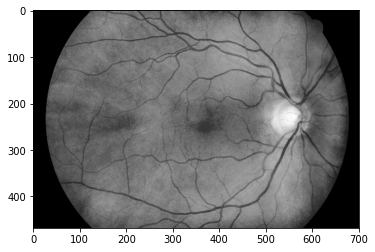

In [3]:
image = cv.imread('data/all/images/07_h.JPG')
mask = cv.imread('data/all/manual1/07_h.tif')
cut = cv.imread('data/all/mask/07_h_mask.tif')

image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
l, a, b = cv.split(image_lab)
clahe = cv.createCLAHE(clipLimit = 3.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2RGB)
tile_size = 5
merged = cv.bitwise_and(merged, cut)

merged = cv.copyMakeBorder(merged,
                           tile_size - merged.shape[0] % tile_size,
                           0,
                           tile_size - merged.shape[1] % tile_size,
                           0,
                           cv.BORDER_CONSTANT,
                           value = [0, 0, 0])

mask = cv.copyMakeBorder(mask,
                         tile_size - mask.shape[0] % tile_size,
                         0,
                         tile_size - mask.shape[1] % tile_size,
                         0,
                         cv.BORDER_CONSTANT,
                         value = [0, 0, 0])

merged_gray = cv.cvtColor(merged, cv.COLOR_RGB2GRAY)

merged = cv.resize(merged, (0, 0), fx = 0.2, fy = 0.2)
mask = cv.resize(mask, (0, 0), fx = 0.2, fy = 0.2)
merged_gray = cv.resize(merged_gray, (0, 0), fx = 0.2, fy = 0.2)

imshow(merged_gray, cmap = 'gray')


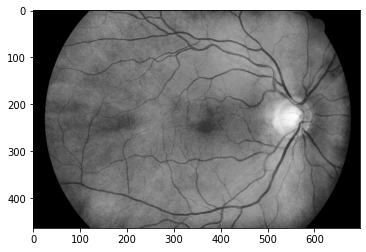

In [4]:
strides = merged_gray.strides * 2
merged_shape = [merged_gray.shape[0] - tile_size + 1, merged_gray.shape[1] - tile_size + 1, tile_size, tile_size]
data = np.lib.stride_tricks.as_strided(merged_gray, shape = merged_shape, strides = strides)
mask = np.lib.stride_tricks.as_strided(mask, shape = merged_shape, strides = strides)
mask = data.reshape(-1, tile_size, tile_size)
data = data.reshape(-1, tile_size, tile_size)
r = np.zeros((data.shape[0]))

for i in range(data.shape[0]):
    r[i] = data[i][2][2]

r = r.reshape((464, 697))
imshow(r, cmap = 'gray')

undersampler = RandomUnderSampler(sampling_strategy = 'auto')


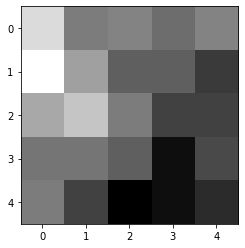

In [5]:
imshow(data[177000], cmap = 'gray')
moments_0 = np.zeros((data.shape[0]))
moments_1 = np.zeros((data.shape[0]))
moments_2 = np.zeros((data.shape[0]))
moments_3 = np.zeros((data.shape[0]))
moments_4 = np.zeros((data.shape[0]))
moments_5 = np.zeros((data.shape[0]))
moments_6 = np.zeros((data.shape[0]))
for i in range(0, data.shape[0], 10):
    m = cv.moments(data[i])
    moments_0[i] = cv.HuMoments(m)[0]
    moments_1[i] = cv.HuMoments(m)[1]
    moments_2[i] = cv.HuMoments(m)[2]
    moments_3[i] = cv.HuMoments(m)[3]
    moments_4[i] = cv.HuMoments(m)[4]
    moments_5[i] = cv.HuMoments(m)[5]
    moments_6[i] = cv.HuMoments(m)[6]


In [6]:
means = np.mean(data, axis = (1, 2))
_vars = np.var(data, axis = (1, 2))


In [7]:
truth = np.zeros((mask.shape[0]), dtype = 'uint8')
tile_coords = np.zeros((mask.shape[0], 2))
for i in range(mask.shape[0]):
    truth[i] = 1 if mask[i][tile_size // 2][tile_size // 2] > 127 else 0


In [8]:
data = [
    means.flatten(),
    _vars.flatten(),
    moments_0.flatten(),
    moments_1.flatten(),
    moments_2.flatten(),
    moments_3.flatten(),
    moments_4.flatten(),
    truth.flatten()
]
# print(data)
# data = data[np.random.choice(len(data), size=100000)]
knn_data_frame = pd.DataFrame(
    data, index = ['mean', 'var', 'moment 0', 'moment 1', 'moment 2', 'moment 3', 'moment 4', 'truth']).transpose()
knn_data_frame = knn_data_frame[knn_data_frame['mean'] > 0]
dt = table(knn_data_frame)
display(dt)

RegularTableWidget()

In [9]:
X = knn_data_frame.iloc[:, 0:7]
y = knn_data_frame.iloc[:, 7]
parameters, truth = undersampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
kNN = KNeighborsClassifier(n_neighbors = 11, p = 2, metric = 'euclidean')
kNN.fit(X_train, y_train)
dump(kNN, 'kNN_classifier.joblib')


['kNN_classifier.joblib']

In [10]:
y_pred = kNN.predict(X_test)
y_pred

array([0., 0., 0., ..., 1., 0., 0.])

In [11]:
print(y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)


[0. 0. 0. ... 1. 0. 0.]
accuracy: 0.9489755500342083
sensitivity :  0.8627240143369176
specificity:  0.9706637826145734


### Classifier testing

In [21]:
kNN_classifier = load('kNN_classifier.joblib')
image = cv.imread('data/all/images/04_h.JPG')
mask = cv.imread('data/all/manual1/04_h.tif')
cut = cv.imread('data/all/mask/04_h_mask.tif', cv.IMREAD_GRAYSCALE)

In [13]:
new_image_data_frame = prepare_image(image, mask, cut)

In [15]:
new_X = new_image_data_frame.iloc[:, 0:7]
image_pred = kNN_classifier.predict(new_X)

e:\Projects\Studia\S6\Informatyka w Medycynie\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


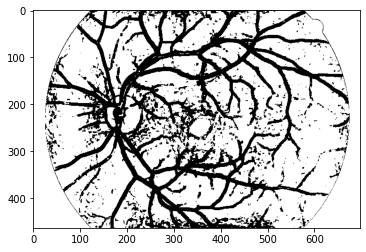

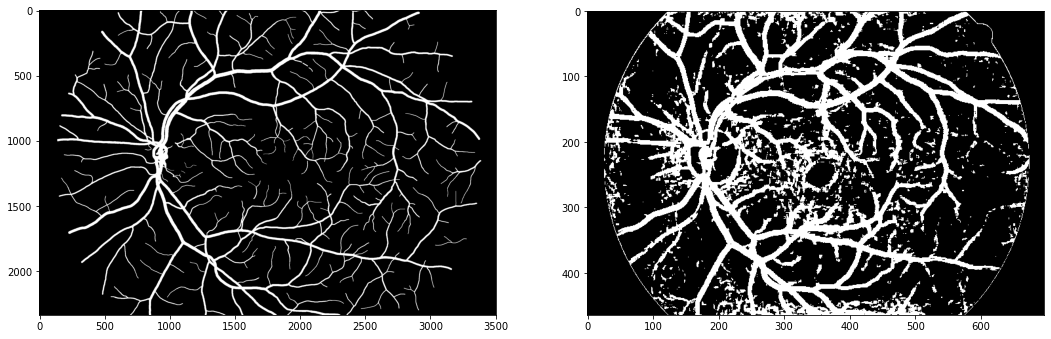

In [35]:
predicted_image_to_display = image_pred.reshape((464, 697)).astype('uint8')
# cut = cv.cvtColor(cut, cv.COLOR_BGR2GRAY)
cut = cv.resize(cut, (predicted_image_to_display.shape[1], predicted_image_to_display.shape[0]))
inversed_image = predicted_image_to_display.copy()
inversed_image[cut == 0] = 1
imshow(inversed_image, cmap = 'gray')
inversed_image = cv.bitwise_not(inversed_image)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(mask, cmap = 'gray')
ax2.imshow(inversed_image, cmap = 'gray')


## Deep neural network

In [363]:
from keras_unet.models import custom_unet
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras.optimizers import SGD

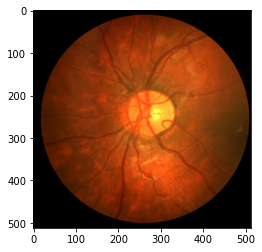

In [352]:
image = cv.imread('data/cnn/CHASEDB1/Image_01L.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = image[:, :image.shape[0]]
image = cv.resize(image, (512, 512))
imshow(image)

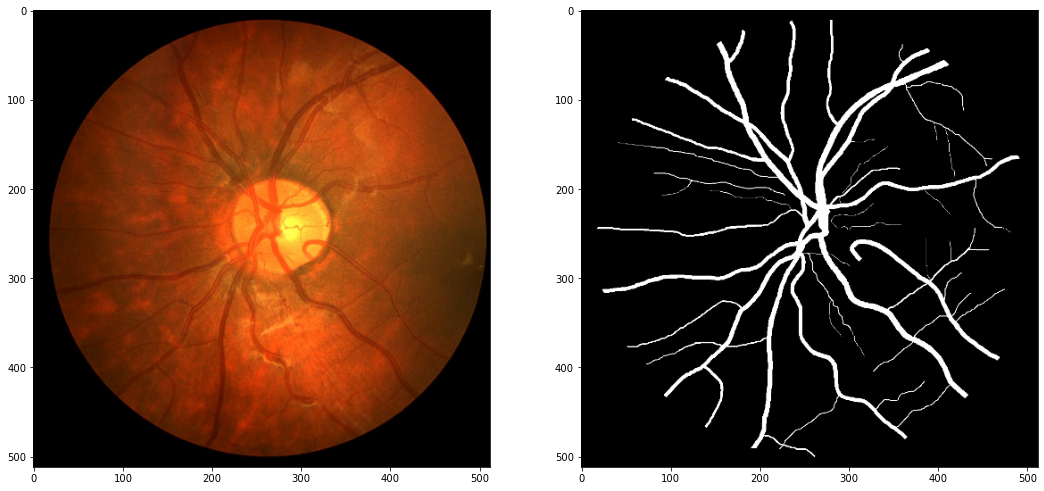

In [361]:
train_set = []
ground_truths = []
for i in range(1, 10):
    image = cv.imread('data/cnn/CHASEDB1/Image_' + str(i).zfill(2) + 'L.jpg')
    mask = cv.imread('data/cnn/CHASEDB1/Image_' + str(i).zfill(2) + 'L_1stHO.png')
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = image[:, :image.shape[0]]
    image = cv.resize(image, (512, 512))
    mask = mask[:, :mask.shape[0]]
    mask = cv.resize(mask, (512, 512))
    train_set.append(image)
    ground_truths.append(mask)

train_set = np.asarray(train_set)
ground_truths = np.asarray(ground_truths)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(train_set[0])
ax2.imshow(ground_truths[0], cmap = 'gray')


In [364]:
model_checkpoint_callback = ModelCheckpoint(filepath = 'monitor.h5',
                                            save_weights_only = True,
                                            monitor = 'val_accuracy',
                                            mode = 'max',
                                            save_best_only = True)

cnn = custom_unet((512, 512),
                  use_batch_norm = False,
                  num_classes = 1,
                  filters = 64,
                  dropout = 0.5,
                  output_activation = 'sigmoid')

cnn.compile(optimizer = SGD(lr = 0.01, momentum = 0.99),
            loss = 'binary-crossentropy',
            run_eagerly = True,
            metrics = [iou, iou_thresholded])


ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 512, 512)